## Model
<figure><img src="../../../images/hill model.png\" width=400 />


## Deduction

   $ F_{SEE} = \left\{\begin{array}{l}
   0\ \ , \ \ L_T < L_{SL}\\
   K(L - L_{SL})^2 \ \ , \ \ L_T \geq L_{SL}\\
   \end{array}
   \right.$
   
   $F_{KPE} = \left\{\begin{array}{l}
   0\ \ , \ \ L_{CE} < L_{op}\\
   K(L - L_{op})^2 \ \ , \ \ L_{CE} \geq L_{op}\\
   \end{array}
   \right.$
     
  
   $F = \frac{F_{SEE}}{cos(\alpha)} - F_{KPE} = F_{CE} $
     
   $\dot L_{CE} = (0.25 + 0.75a)V_{max}\frac{F_{CE}-aF_L}{b} $
   
   $ b = \left\{\begin{array}{l}
   aF_L + F_{CE}/A_f\ \ , \ \ F_{CE} < F_L\\
   \frac{(2 + 2/A_f)(aF_L\overline{F}^M_{len} - F_{CE})}{\overline{F}^M_{len} - 1}   \ \ , \ \ F_{CE} \geq F_L\\
   \end{array}
   \right.$
   
   $\frac{da}{dt} = \frac{u - a}{\tau_a(u,a)}$
   
   $\tau_a(a,u) = \left\{\begin{array}{l}
   \tau_{act}(0.5 + 1.5a)\ \ , \ \ u > a\\
   \frac{\tau_{dact}}{(0.5 + 1.5a)}\ \ , \ \ u \leq a\\
   \end{array}
   \right.$
   
   $L_{SEE} = L_m - L_{CE} cos(\alpha)$

In [668]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib notebook
from Muscle import Muscle

In [669]:
8.8*0.03

0.264

In [670]:
#Muscle properties -Parameters obtained from Table 2 of Thelen (2003).

####### Dorsiflexor

Lce_o_DOR = 0.09 #optimal length of CE (meter)(telen 2003 dorsiflexor)
Lslack_DOR = 2.4*Lce_o_DOR #slack length of SEE, SEE strain at Fmax (meters)(telen 2003 dorsiflexor)
Fmax_DOR = 1400 #maximal isometric force (Newton)(telen 2003 dorsiflexor)
alpha_DOR = 7*np.pi/180 #penation angle degree

####### Soleus

Lce_o_SOL = 0.03 #optimal length of CE (meter)(telen 2003 dorsiflexor)
Lslack_SOL = 8.8*Lce_o_SOL #slack length of SEE, SEE strain at Fmax (meters)(telen 2003 dorsiflexor)
Fmax_SOL = 8050 #maximal isometric force (Newton)(telen 2003 dorsiflexor)
alpha_SOL = 25*np.pi/180 #penation angle (Input the valeu in degrees)

############################################################################################################################

#Activation Parameter
tau_dact = 50e-3 #young #ms
#tal_dact = 0.060 #old #ms
tau_act = 15e-3 #ms


############################################################################################################################

#Contract Elemente
Af = 0.25
F_m_len = 1.4 #young
#F_m_len = 1.8 #old
v_max = 10 #young
#v_max = 8 #old

############################################################################################################################

dt = 1e-4

In [671]:
As_TA  = np.array([30.6, -7.44e-2, -1.41e-4,  2.42e-6,  1.50e-8])/100
Bs_TA  = np.array([ 4.3,  1.66e-2, -3.89e-4, -4.45e-6, -4.34e-8])/100
As_SOL = np.array([32.3,  7.22e-2, -2.24e-4, -3.15e-6,  9.27e-9])/100
Bs_SOL = np.array([-4.1,  2.57e-2,  5.45e-4, -2.22e-6, -5.50e-9])/100

In [672]:
dorsiflexor = Muscle(Lslack = Lslack_DOR, Lce_o = Lce_o_DOR, Fmax = Fmax_DOR, alpha = alpha_DOR, tau_dact = tau_dact, 
                     tau_act = tau_act, dt = dt, Af = Af, F_m_len = F_m_len, v_max = v_max)
soleus      = Muscle(Lslack = Lslack_SOL, Lce_o = Lce_o_SOL, Fmax = Fmax_SOL, alpha = alpha_SOL, tau_dact = tau_dact, 
                     tau_act = tau_act, dt = dt, Af = Af, F_m_len = F_m_len, v_max = v_max)

## Parameters

In [673]:
soleus.Lslack

0.264

In [674]:
## Muscle properties for human Vastus Lateralis

##parameters for the equation of motion (Nigg & Herzog, p. 562)
M = 75 #total mass in kg
proportion_mass = 0.0145
m = M*proportion_mass #kg
Lseg = 0.26 #meters
CM = 0.5 #Center of Mass
Rcm = CM*Lseg #distance knee joint to centre of mass(meter)
Rg_norm = 0.69
I = m*(Rg_norm*Lseg)**2  #moment of inertia
theta_leg = np.pi/2

##Initial condition
phi = 0
phid = 0 #start as 90 degree flexion and zero velocity

dorsiflexor.Lnorm_ce = (As_TA[0]  - dorsiflexor.Lslack)/(dorsiflexor.Lce_o) #norm
soleus.Lnorm_ce      = (As_SOL[0] - soleus.Lslack)/(soleus.Lce_o) #norm

tf = 1.0

u_dor = 1 #initial activation
u_sol=  0.001 #initial activation

t = np.arange(0,tf,dt)
a_vector =  np.empty_like(t)
F_kpe_norm = np.empty_like(t)
F_CE_norm = np.empty_like(t)
F_tot = np.empty_like(t)
F_tot2 = np.empty_like(t)
fiber_length = np.empty_like(t)
tendon_length = np.empty_like(t)
angle_phi = np.empty_like(t)
velocity_phi = np.empty_like(t)
fibervelocity = np.empty_like(t)
Rf_v = np.empty_like(t)
Lm_v = np.empty_like(t)
moment = np.empty_like(t)
a_sol = np.empty_like(t)

## Functions

In [675]:
(As_SOL[0] - soleus.Lslack)/(soleus.Lce_o)

1.9666666666666648

In [676]:
np.cos(soleus.alpha)

0.9063077870366499

In [677]:
def computeMomentArm(phi,Bs):
    """
    Inputs:
        phi - joint's flexion degree 
    Output:
        Rf - joint's moment arm of 
    """
    theta_degree = math.degrees(phi)
    Rf = 0
    
    for i in range(len(Bs)):
        Rf = Rf + (Bs[i]*theta_degree**i)
        
    return Rf

In [678]:
def computeTotalLenghtSize(phi,As):
    """
    Inputs:
        Phi = joint's flexion degree 
    Output:
        Lm = total muscle lenght
    """

    theta_degree = math.degrees(phi)
    Lm = 0
    
    for i in range(len(As)):
        Lm = Lm + (As[i]*theta_degree**i)
        
    
    return Lm

In [679]:
def computeMomentKnee(Rf_TA,F0norm_TA,m,Rcm,phi,Fmax_TA,theta_leg,Rf_SOL, F0norm_SOL, Fmax_SOL):
    """"
    Inputs:
        RF = Moment arm
        F = Normalized tendon force
        m = Segment Mass
        g = Acelleration of gravity
        Fmax= maximal isometric force
    Output:
        M = Total moment with respect to joint
    """
    
    g = 9.81
    
    M = Rf_TA*F0norm_TA*Fmax_TA + Rf_SOL*F0norm_SOL*Fmax_SOL - m*g*Rcm*np.sin(theta_leg-phi)
    
    return M

In [680]:
def computeFlexionAngleVelocity(M,I):
    """
    Inputs:
        M = Total moment with respect to joint
        I = Moment of Inertia
    Output:
        phidd= angular aceleration of the joint
    """

    phidd = M/I #angular acceleration
    
    return phidd

In [681]:
dorsiflexor.F_tendon_norm

0

## Muscle Model

In [682]:
for i in range(len(t)):
        
    #################################################################################################################
    
    Rf_TA = computeMomentArm(phi,Bs_TA)
    Lm_TA = computeTotalLenghtSize(phi,As_TA)
    Rf_SOL = computeMomentArm(phi,Bs_SOL)
    Lm_SOL = computeTotalLenghtSize(phi,As_SOL)
    
    
    dorsiflexor.updateMuscle(Lm = Lm_TA, u = u_dor)
    soleus.updateMuscle(Lm = Lm_SOL, u = u_sol)
    
    if phi*180/np.pi < 5:
        u_dor = 1
        u_sol = 0.001
    else:
        u_dor = 0.001
        u_sol = 1
    
    #################################################################################################################
    
    M =  computeMomentKnee(Rf_TA, dorsiflexor.F_tendon_norm, m, Rcm, phi, dorsiflexor.Fmax, theta_leg, Rf_SOL, 
                           soleus.F_tendon_norm, soleus.Fmax) # total moment with respect to knee joint
    
    phidd = computeFlexionAngleVelocity(M,I)
    
    phid = phid+ dt*phidd
    
    phi = phi + phid*dt
    
    #################################################################################################################
    
    F_tot[i] = dorsiflexor.F_tendon_norm* dorsiflexor.Fmax
    F_tot2[i] = soleus.F_tendon_norm*soleus.Fmax
    fiber_length[i] =  dorsiflexor.Lnorm_ce* dorsiflexor.Lce_o
    tendon_length[i] = dorsiflexor.Lnomr_see* dorsiflexor.Lce_o
    a_vector[i] =  dorsiflexor.a
    a_sol[i] = soleus.a
    velocity_phi[i] = phid
    angle_phi[i] = phi
    fibervelocity[i] = dorsiflexor.Lnorm_cedot* dorsiflexor.Lce_o
    Rf_v[i] = Rf_TA
    Lm_v[i] = Lm_TA
    moment[i] = M
        

    

## Tendon Force

<IPython.core.display.Javascript object>


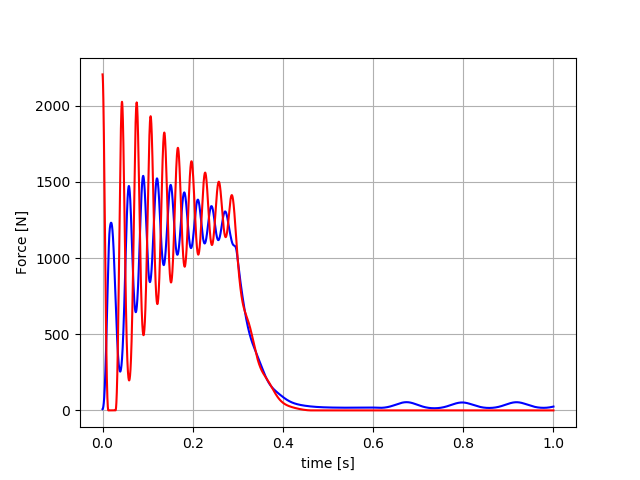

Text(0,0.5,'Force [N]')

In [683]:
plt.figure()
plt.plot(t,F_tot, c = 'blue')
plt.plot(t,F_tot2, c = 'red')
plt.grid()
plt.xlabel ('time [s]')
plt.ylabel ('Force [N]')

## Length

<IPython.core.display.Javascript object>


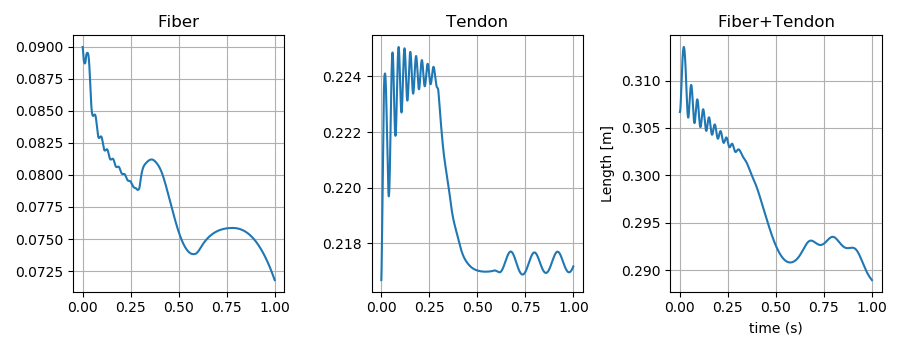

In [684]:
fig,  ax  =  plt.subplots(1, 3, figsize=(9, 3.5), sharex=True)

ax[0].plot(t, fiber_length, label = 'Fiber')
ax[0].set_title('Fiber')
ax[0].grid()
ax[1].plot(t, tendon_length, label = 'Tendon')
ax[1].set_title('Tendon')
ax[1].grid()
ax[2].plot(t, fiber_length+tendon_length, label = 'Fiber+Tendon')
ax[2].set_title('Fiber+Tendon')
ax[2].grid()
plt.xlabel('time (s)')
plt.ylabel('Length [m]')
plt.tight_layout()


## Activation

<IPython.core.display.Javascript object>


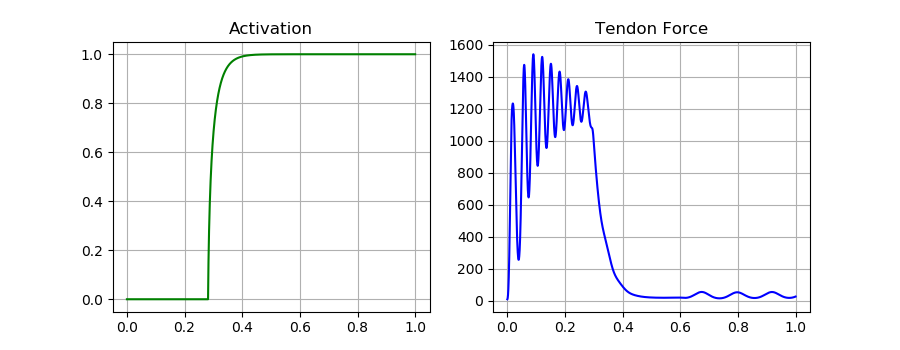

In [685]:
fig,  ax  =  plt.subplots(1, 2, figsize=(9, 3.5), sharex=True)

ax[0].plot(t, a_sol, c = 'green')
ax[0].set_title('Activation')
ax[0].grid()
ax[1].plot(t, F_tot, c = 'blue')
ax[1].set_title('Tendon Force')
ax[1].grid()

## Joint Moment

<IPython.core.display.Javascript object>


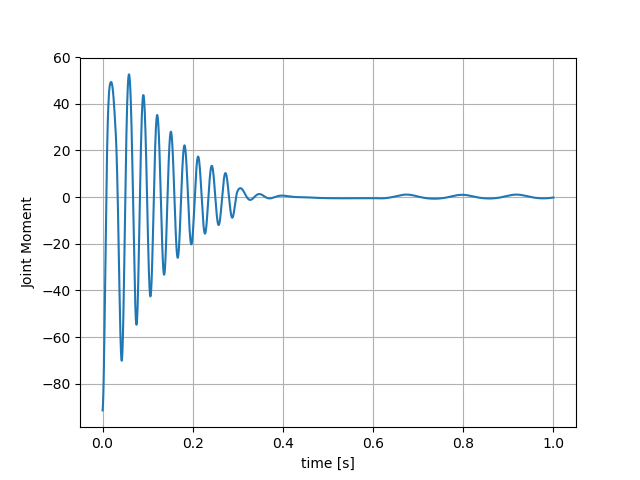

Text(0,0.5,'Joint Moment')

In [686]:
plt.figure()
plt.plot(t,moment,)
plt.grid()
plt.xlabel ('time [s]')
plt.ylabel ('Joint Moment')

## Angle and Velocity

<IPython.core.display.Javascript object>


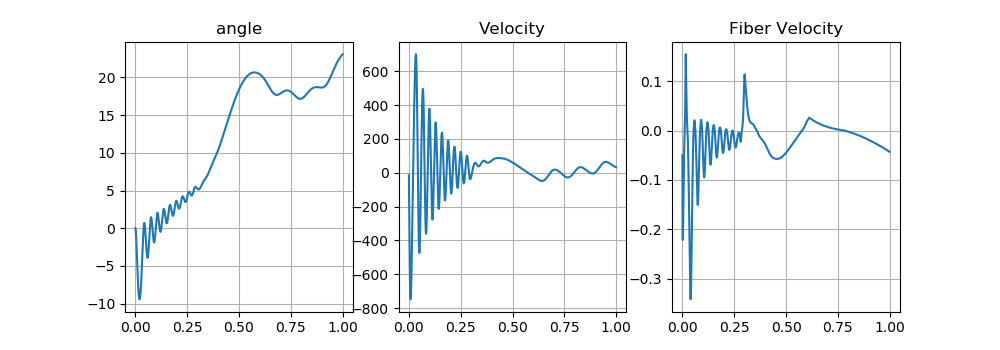

In [687]:
fig,  ax  =  plt.subplots(1, 3, figsize=(10, 3.5), sharex=True)

ax[0].plot(t, angle_phi*180/np.pi)
ax[0].set_title('angle')
ax[0].grid()
ax[1].plot(t, velocity_phi*180/np.pi)
ax[1].set_title('Velocity')
ax[1].grid()
ax[2].plot(t,fibervelocity)
ax[2].set_title('Fiber Velocity')
ax[2].grid()